In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Cargar el archivo CSV y convertir la columna 'Date' a datetime

In [ ]:
file_path = 'Top10VideoGameStocks.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)

# Entender el dataset para decidir que variables se van a trabajar

#### Cabe aclarar que escogí un dataset bastante depurado para enfocarme en la implementacion del modelo y entendimiento de los resultados/desempeño

In [ ]:
df.describe

<bound method NDFrame.describe of            Date                         Company Ticker Symbol Currency  \
0    2000-01-01  Sony Interactive Entertainment          SONY      JPY   
1430 2000-01-01                 Electronic Arts            EA      USD   
1728 2000-01-01            Take-Two Interactive          TTWO      USD   
840  2000-01-01                        Nintendo         NTDOY      USD   
542  2000-01-01                Microsoft Gaming          MSFT      USD   
...         ...                             ...           ...      ...   
839  2024-10-01                Microsoft Gaming          MSFT      USD   
1137 2024-10-01                        Nintendo         NTDOY      USD   
2120 2024-10-01                  Embracer Group   EMBRAC-B.ST      SEK   
1429 2024-10-01                   NetEase Games          NTES      USD   
2208 2024-10-01                        Playtika          PLTK      USD   

            Open        High         Low       Close   Adj Close      Volume 

# Seleccionar las columnas relevantes


In [ ]:
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Adj Close']

# Dividir los datos en conjuntos de entrenamiento y prueba (80/20)


#### 80% del dataset se utiliza para entrenar y el 20% para testeo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Instanciar y entrenar el modelo XGBoost (Algoritmo de regresion)

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Evaluar desempeño del modelo

In [ ]:

y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 17.060143618875994


#### El error cuadratico medio es 17, para determinar si es un error "aceptable" debo compararlo con la media para determinar cuando impacto tiene 

# Calcular la media de 'Adj Close' en el conjunto de prueba

In [ ]:
mean_adj_close = y_test.mean()
print(f"Media de 'Adj Close': {mean_adj_close}")

Media de 'Adj Close': 121.24753107636224


# Comparar el RMSE con la media

In [ ]:
rmse_percentage = (rmse / mean_adj_close) * 100
print(f"El RMSE representa aproximadamente un {rmse_percentage:.2f}% del valor promedio de 'Adj Close'.")

El RMSE representa aproximadamente un 14.07% del valor promedio de 'Adj Close'.


# Gráfico de Residuales (diferencia entre valores reales y predicciones)


##### El % del error cuadratico medio representar el 14% y segun el grafico residual los valores no se encuentran sesgados y hay presencia de outliers (aunque pocos)

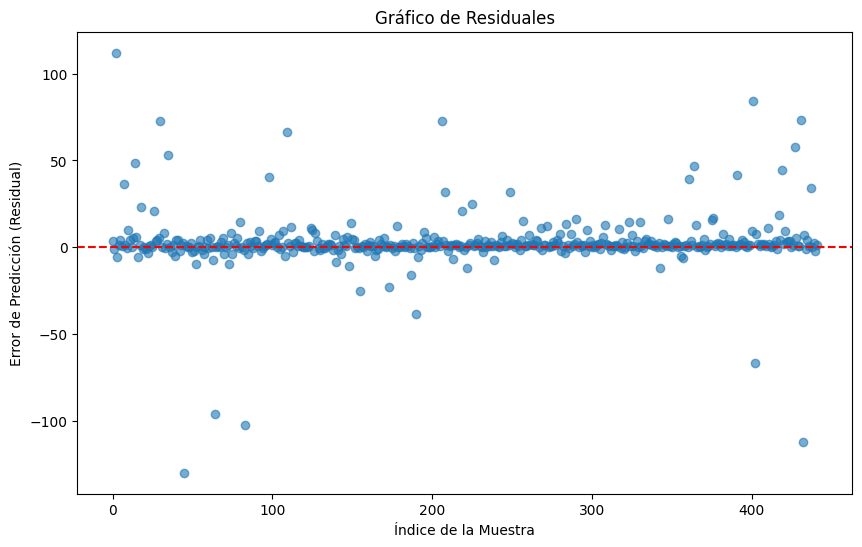

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de Residuales')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Error de Predicción (Residual)')
plt.show()


# Calcular MAE (Error Absoluto Medio) para más contexto


In [ ]:
mae = np.mean(np.abs(residuals))
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 6.455025034252874


Comparación RMSE vs. MAE: el RMSE es algo mayor que el MAE, lo que indica que hay errores medianamente grandes, pero no extremadamente severos.
Lo cual quiere decir que el modelo tiene puntos de mejora pero es funcional, aunque eso lo determina el area de negocio que tiene una vision mas holistica de lo que implica este porcentaje.
Para mejorar el desempeño del modelo se podrían tomar la siguientes decisiones:
* Validar si los outliers tiene una causa si se puedan eliminar, esto tendría un impacto muy positivo en la precisión del modelo
* Ajustar hiperparametros para gestionar mejor los datos extremos
* Experimentar con mas modelos

# Validación cruzada usando RMSE


##### El error cuadrático medio del modelo a través de las diferentes particiones (5) de la validación cruzada es 6.77 .En vista del precio promedio de los juegos este valor es muy bueno

In [ ]:
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
mean_cv_rmse = -cv_scores.mean()
print(f"Cross-Validated RMSE: {mean_cv_rmse:.2f}")

Cross-Validated RMSE: 6.77


# Errores vs Valores ajustados

##### El siguente grafico nos dice que entre mas pegado a la linea roja indica que no hay error. Como logramos ver la mayoria de predicciones son correctas y los puntos mas alejados de la linea roja  indican una distribución aleatoria a pesar de ser constante

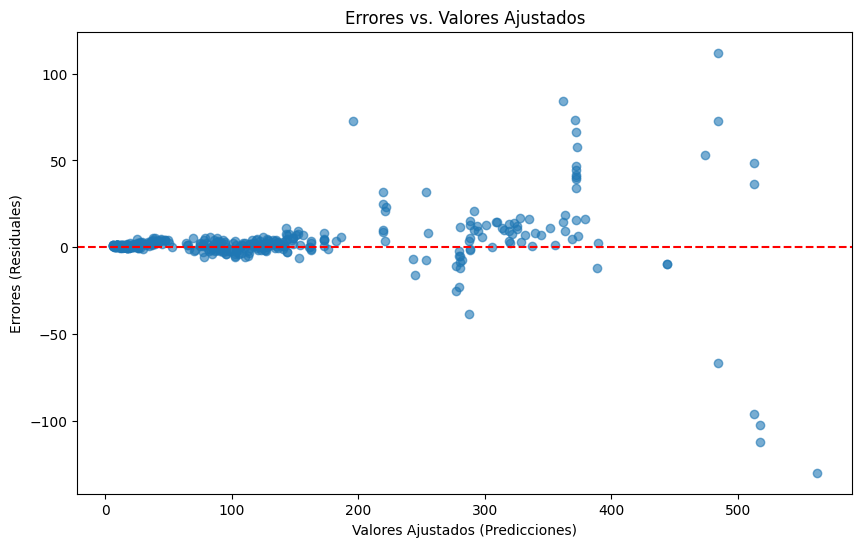

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Errores vs. Valores Ajustados')
plt.xlabel('Valores Ajustados (Predicciones)')
plt.ylabel('Errores (Residuales)')
plt.show()


# Learning Curve (Curva de Aprendizaje)

##### El gráfico muestra una curva de cprendizaje típica donde a medida que aumenta el tamaño del conjunto de entrenamiento, la capacidad de generalización del modelo mejora. Podriamos decir que es un buen indicador de que el modelo está aprendiendo correctamente y que el aumento de datos de entrenamiento ha mejorado su desempeño. Resultado muy positivo :)

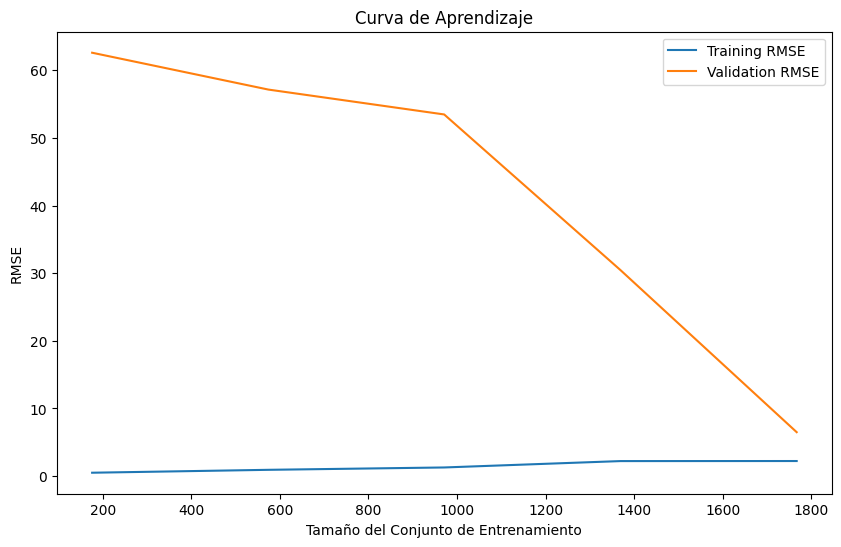

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(xgb_model, X, y, cv=5, scoring='neg_root_mean_squared_error')

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training RMSE')
plt.plot(train_sizes, -test_scores.mean(axis=1), label='Validation RMSE')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.show()


# Análisis de Sesgos de Predicción

##### Según el siguiente histograma la mayoriái de predicciones de acercan a 0 lo que indica que generalmente el modelo predice bien, el ancho de la distrubución es consistente y no parece indicar sesgos sistematicos

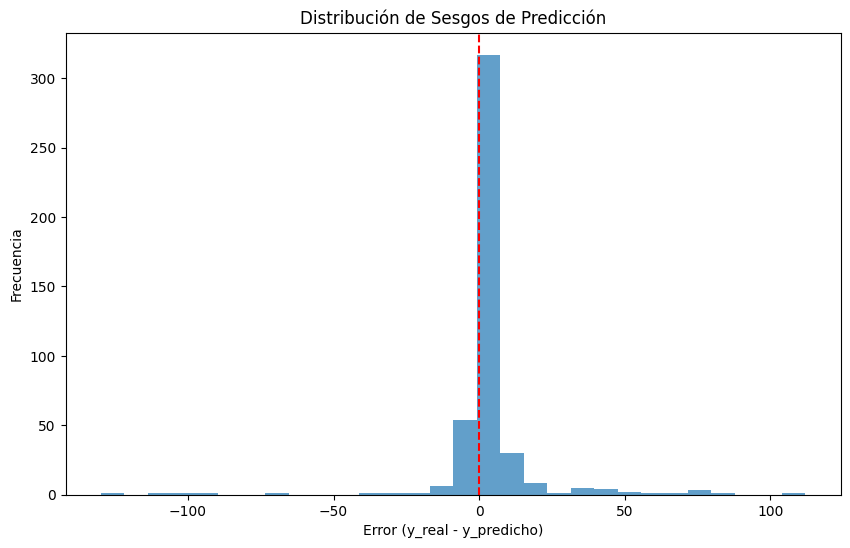

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribución de Sesgos de Predicción')
plt.xlabel('Error (y_real - y_predicho)')
plt.ylabel('Frecuencia')
plt.show()
